In [1]:
import scipy
import numpy as np
import pandas as pd
from learner import learner
from hw2_resources.plotBoundary import *
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# kernels we're using
def gaussian_kernel(x, y, s = 1):
    return scipy.exp(-(np.linalg.norm(x - y))**2 / (s**2))

def linear_kernel(x,y):
    return np.dot(x,y)

# Toy Problem

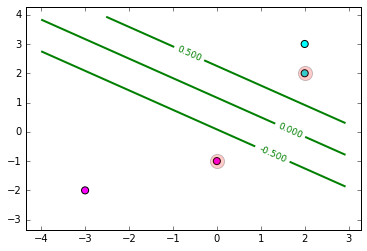

In [3]:
X = np.array([[2,2],[2,3],[0,-1], [-3, -2]])
Y = np.array([1, 1, -1, -1]).reshape((4,1))

svm = learner()
svm.set_data(X,Y)
svm.set_kernel_function(linear_kernel)
svm.make_kernel_matrix()
constraints = svm.train(1)
plotDecisionBoundary(X, Y, scoreFn = svm.predict, values = (-0.5, 0, 0.5))
plt.gca().scatter(svm.support_vectors[:,0],
            svm.support_vectors[:,1], 
            s = 200,
            c = 'red',
            alpha = .2) # ugly but whatevs

In [4]:
for constraint in constraints:
    print constraint, constraints[constraint]

A [ 1.00e+00  1.00e+00 -1.00e+00 -1.00e+00]

b [ 0.00e+00]

G [ 1.00e+00  0.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00  1.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00  1.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]
[-1.00e+00 -0.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -1.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -1.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -0.00e+00 -1.00e+00]

h [ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[-0.00e+00]
[-0.00e+00]
[-0.00e+00]
[-0.00e+00]

q [-1.00e+00]
[-1.00e+00]
[-1.00e+00]
[-1.00e+00]

P [ 8.00e+00  1.00e+01  2.00e+00  1.00e+01]
[ 1.00e+01  1.30e+01  3.00e+00  1.20e+01]
[ 2.00e+00  3.00e+00  1.00e+00  2.00e+00]
[ 1.00e+01  1.20e+01  2.00e+00  1.30e+01]



# Linear Kernel for Each Data Set

In [5]:
def data_path(i, type):
    return 'hw2_resources/data/data' + str(i) + '_' + type + '.csv'

def plot_data(i, X, Y, values, ax, title = None):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = max((x_max-x_min)/20., (y_max-y_min)/20.)
    xx, yy = meshgrid(arange(x_min, x_max, h),
                      arange(y_min, y_max, h))
    zz = array([svm.predict(x) for x in c_[xx.ravel(), yy.ravel()]])
    zz = zz.reshape(xx.shape)

    CS = ax.contour(xx, yy, zz, values, colors = 'black', linestyles = 'dashed', linewidths = 2)
    ax.clabel(CS, fontsize=9, inline=1)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=(1.-Y), s=50, cmap = pl.cm.cool)
    ax.set_title(title)
#     ax.axis('tight')

def read_data(path):
    data = pd.read_table(path, sep = ' ', header = None)
    X = np.array(data[[0,1]])
    Y = np.array(data[[2]])
    return((X,Y))

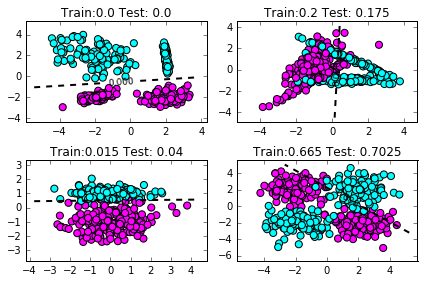

In [6]:
fig = plt.figure()
C = 1

for i in [1, 2, 3, 4]:

    X,Y = read_data(data_path(i, 'train'))

    svm = learner()
    svm.set_data(X,Y)
    svm.set_kernel_function(linear_kernel)
    svm.make_kernel_matrix()
    svm.train(C)
    
    X_val, Y_val = read_data(data_path(i, 'validate'))
    
    training_error = svm.training_error()
    validation_error = svm.test_error(X_val, Y_val)
    
    ax = fig.add_subplot(2,2,i)
    plot_data(i, X, Y, (0), ax, 'Train:' + str(training_error) + ' Test: ' + str(validation_error))
plt.tight_layout()

# Gaussian Kernel: Messing with $C$

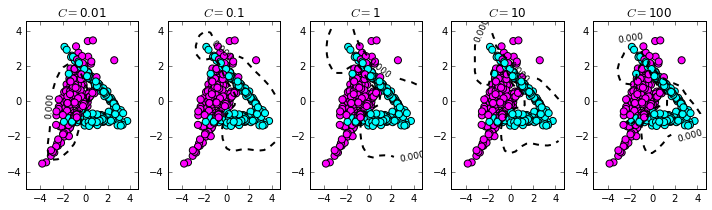

In [7]:
table = pd.DataFrame({'C' : [],
                      'Training Error': [],
                      'Validation Error': [],
                      'Margin': [],
                      'Support Vectors': []})

Cs = [10 ** p for p in range(-2, 3)]
fig = plt.figure(figsize = (10, 3))

i = 2
for j in range(len(Cs)):
    X,Y = read_data(data_path(i, 'train'))
    svm = learner()
    svm.set_data(X,Y)
    svm.set_kernel_function(gaussian_kernel)
    svm.make_kernel_matrix()
    svm.train(Cs[j])
    
    X_val, Y_val = read_data(data_path(i, 'validate'))
    
    training_error = svm.training_error()
    validation_error = svm.test_error(X_val, Y_val)
    margin = svm.get_margin()
    n_supports = len(svm.get_supports())
    
    ax = fig.add_subplot(1,len(Cs),j+1)
    plot_data(j+1, X, Y, (0), ax, r'$C = $' + str(Cs[j]))
    
    add_to_table = pd.DataFrame({'C' : [Cs[j]],
                      'Training Error': [training_error],
                      'Validation Error': [validation_error],
                                'Margin' : margin,
                                'Support Vectors' : n_supports})
    table = table.append(add_to_table)
plt.tight_layout()

In [8]:
table # summarize the results

,C,Margin,Support Vectors,Training Error,Validation Error
0,0.01,25.641071,391,0.1100,0.130
0,0.10,0.454533,276,0.0850,0.125
0,1.00,0.010060,228,0.0700,0.095
0,10.00,0.000173,135,0.0525,0.095
0,100.00,0.000002,400,0.0350,0.095


In [9]:
np.zeros(X.shape[1])

array([ 0.,  0.])

In [10]:
X

array([[ -2.33903406e-01,  -9.22549325e-01],
       [  1.18151883e+00,  -1.10309630e+00],
       [ -2.46493986e+00,  -2.41956036e+00],
       [  1.55322202e+00,  -1.15509002e+00],
       [  1.27621763e+00,  -1.04805327e+00],
       [  2.39710997e+00,   8.71732474e-02],
       [ -1.34403040e+00,   8.18472503e-01],
       [ -4.69034360e-01,  -7.51710454e-01],
       [ -6.46735016e-01,   6.06647047e-01],
       [ -1.44029872e+00,   8.04109469e-01],
       [ -1.37537243e+00,  -1.16004881e-01],
       [  1.05994811e+00,   1.03747218e+00],
       [ -9.33115123e-01,  -6.72105750e-01],
       [  1.02735575e+00,   9.99444459e-01],
       [ -8.41387781e-01,  -6.55598384e-01],
       [ -2.22585412e+00,  -4.07447840e-01],
       [ -4.25911024e-01,  -5.83676425e-01],
       [  1.03561105e+00,   1.05972780e+00],
       [  9.11255946e-01,  -9.59918736e-01],
       [ -2.26550369e+00,  -1.41720255e+00],
       [ -1.15121409e+00,  -3.41179981e-02],
       [ -2.43317123e+00,  -2.51628576e+00],
       [  